## 1. 들어가며  
object detection 모델로 자율주행 시스템 만들어보기로 함  

전체적 시스템 구성하기 위해 보조장치 역할,  
학습하기 위한 데이터셋 전처리 수행  
-> Detection 모델을 학습시키기 위한 전체 파이프라인 직접 제작하려면 시간 많이 들음  
-> RetinaNet이라는 1-stage detector를 미리 학습 시킨 라이브러리 활용  
(매우 오래 걸림 주의)  

#### 1) 실습 목표
- 바운딩 박스(bounding box) 데이터셋을 전처리할 수 있습니다.  
- Object detection 모델을 학습할 수 있습니다.  
- Detection 모델을 활용한 시스템을 만들 수 있습니다.  


#### 2) 학습 내용  
- 자율주행 보조장치  
- RetinaNet  
- keras-retinanet  
- 프로젝트: 자율주행 보조 시스템 만들기  


#### 3) 기본 세팅 
- 터미널에서 진행  

In [1]:
#프로젝트 위한 디렉토리 생성
! mkdir -p ~/aiffel/object_detection/data

- [RetinaNet 홈페이지](https://github.com/fizyr/keras-retinanet)에서  
  tensorflow 2.3.0, tf.keras 2.4.0을 사용할 것을 권장  
  -> 더 높은 버전에서는 오류가 발생할 수 있음을 안내  

In [ ]:
! pip uninstall tensorflow
! pip install tensorflow==2.3.0

In [1]:
#프로젝트 디렉토리로 이동  
! cd ~/aiffel/object_detection
#repository 받아오기
! git clone https://github.com/fizyr/keras-retinanet.git
#가상환경 내, repository에 필용한 케라스 라이브러리 설치
! cd keras-retinanet && python setup.py build_ext --inplace

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


- 필요사항 설치 : keras-retinanet도 pip 패키지 install

In [ ]:
! pip install -r requirements.txt
! pip install .

-----
## 2. 자율주행 보조장치 (1) KITTI 데이터셋  

#### 1. 자율주행 보조장치 object detection 요구사항  
  1) 사람이 카메라에 감지되면 정지  
  2) 차량이 일정 크기 이상으로 감지되면 정지  
  
  
#### 2. KITTI 데이터셋  
- 자율주행을 위한 데이터셋  
- tensorflow_datasets에서 제공  
- 2D object detection 뿐만 아니라  
  깊이까지 포함한 3D object detection 라벨 등을 제공
  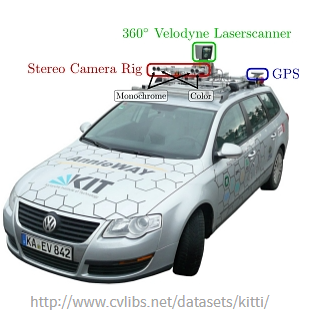  
- [cvlibs에서 제공하는 KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)  


### STEP 0. 필요한 라이브러리 import + 데이터셋 다운로드

##### 1) 라이브러리 import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

##### 2) 데이터셋 다운로드

In [2]:
# 다운로드에 매우 긴 시간이 소요됨
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)


##### 3) 다운로드  KITTI 데이터셋 확인  
- tfds.show_examples() 이용  


- 일반적으로 보는 사진보다 광각으로 촬영  
  -> 다양한 각도의 물체 확인 가능  

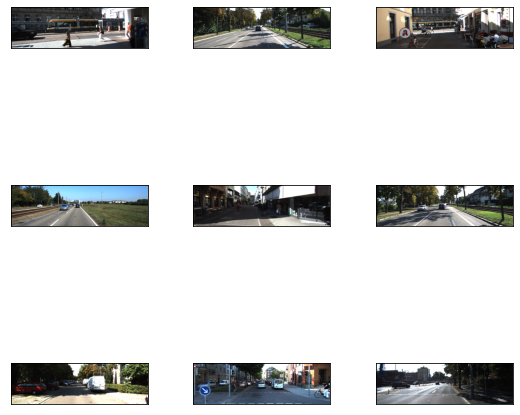

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

##### 4)  데이터셋 정보 확인
- ds_info : 데이터셋 정보 확인 가능  


- training data :  6,347개  
  validation data : 423개  
  test data : 711개  
  
  
- 라벨  
  -> alpha, bbox, dimensions, location, occluded, rotation_y, truncated등의 정보  

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

-----
## 3. 자율주행 보조장치 (2) 데이터 직접 확인하기  

##### 1)  sample 데이터 가져오기  
- ds_train.take(1) : 데이터셋 하나씩 뽑아볼 수 있는 sample 얻음  
  -> 이미지 등의 정보 포함되어 있음  

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([ 2.49,  2.02, -1.89,  0.69,  1.18, -2.76,  2.22], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.8112    , 0.12002415],
       [0.08218667, 0.12618357, 0.43296   , 0.34093398],
       [0.19821334, 0.3427214 , 0.47885334, 0.3698873 ],
       [0.24157333, 0.3879066 , 0.46389332, 0.41333333],
       [0.25085333, 0.3928583 , 0.47552   , 0.4148148 ],
       [0.31794667, 0.4909823 , 0.45938668, 0.53586954],
       [0.35690665, 0.9277536 , 0.49138665, 0.99919486]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[2.48, 2.02, 6.78],
       [1.37, 1.78, 4.65],
       [1.79, 0.66, 0.94],
       [1.77, 0.55, 0.79],
       [1.86, 0.64, 0.84],
       [1.75, 0.65, 1.79],
       [1.48, 1.51, 4.35]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float

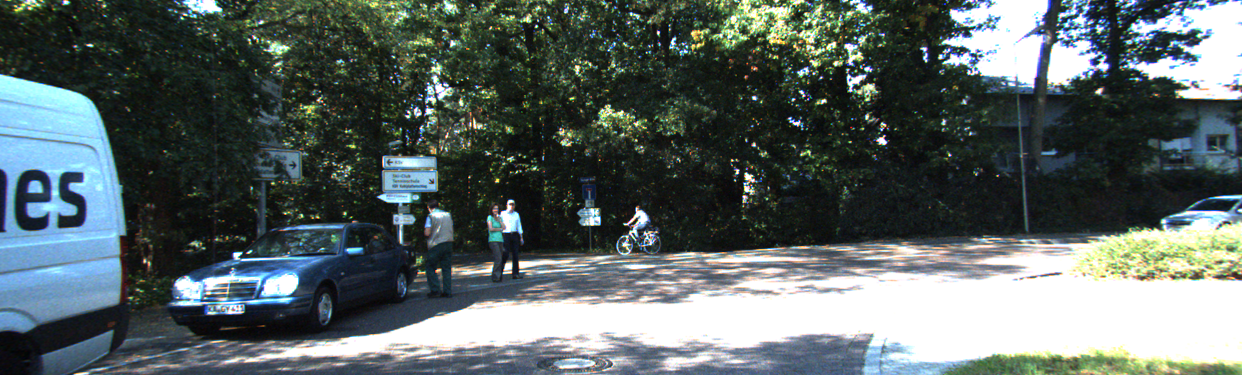

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

##### 2) 바운딩 박스 시각화  
- 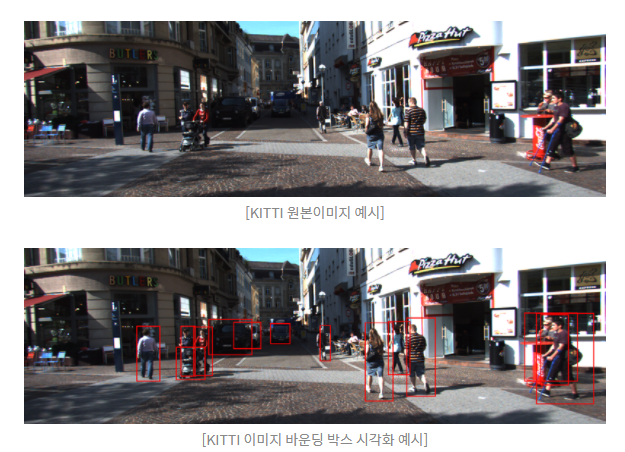  


-  얻은 이미지의 바운딩 박스(bounding box, bbox)를 확인해보자    
  -> 그럼 우선 KITTI에서 제공하는 데이터셋에 대한 설명 확인해보기   
  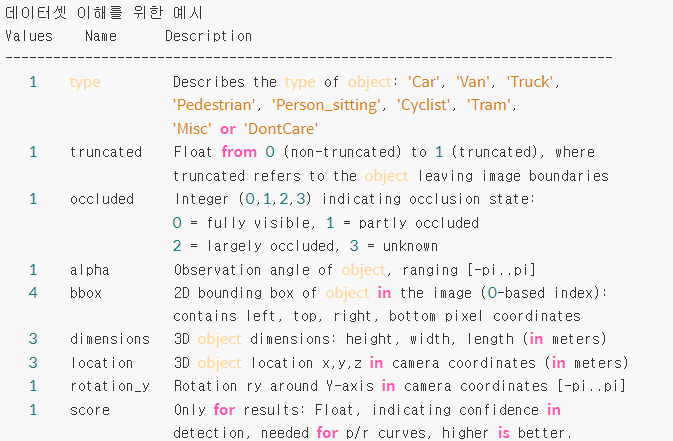  
  위 설명을 바탕으로 함수 생성  
  
  
- [Pillow 라이브러리의 ImageDraw 모듈 참고](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html) 

width: 1242  height: 375
(7, 4)
[  0.      374.      149.06999  70.79999]
[156.71999 344.18    423.44    212.64   ]
[425.65997 300.66998 459.40002 195.43   ]
[481.78    284.41    513.36    201.04001]
[487.93    280.93    515.19995 196.68   ]
[609.8     255.76999 665.55    202.73   ]
[1152.27     241.16    1241.       190.73001]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F1DC43149D0>


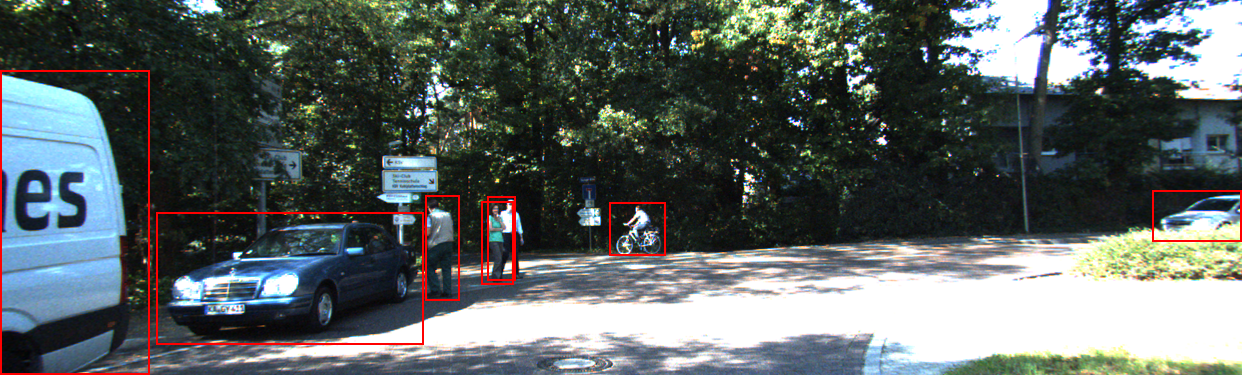

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 4. RetinaNet  
#### 1. 주 참고 자료  
  1) [Focal Loss for Dense Object Detection](https://www.slideshare.net/ssuser06e0c5/focal-loss-detection-classification)  
  2) [김홍배님의 Focal loss의 응용(Detection & Classification)](https://arxiv.org/abs/1708.02002)  
  
  
#### 2. RetinaNet 개념  
- Focal Loss for Dense Object Detection 논문으로 소개된 detection 모델  
- Detection 모델을 직접 만들기에는 많은 시간이 소요 됨  
  -> 미리 모델을 구현한 라이브러리 가져와  
  -> 커스텀 데이터셋에 학습시키고 빠르게 사용
  
  
- 1-stage detector 모델 (YOLO, SSD 등)는  
  2-stage detector 모델 (Faster-RCNN 등) 보다  
  속도는 빠르지만, 성능은 낮음  
  -> 이를 해결하기 위해 : RetinaNet은  
  1) focal loss, 2) FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용  
  
#### 3. Focal Loss  
##### 1)  도입 배경  
- 기존의 1-stage detection 모델들(YOLO, SSD)이  
  물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해  
  한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하기 위해 도입  
  
  
- 그리드? 픽셀?  
  아래 그림 왼쪽 7x7 feature level에선 한 픽셀  
  오른쪽 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field  
  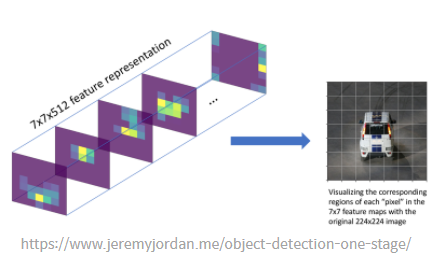  
  
  -> 이처럼 우리가 사용하는 이미지는 물체보다, 많은 배경을 학습하게 됨  
  -> 논문에서는 이를 해결하기 위해 Loss를 개선하여 정확도를 높임   
  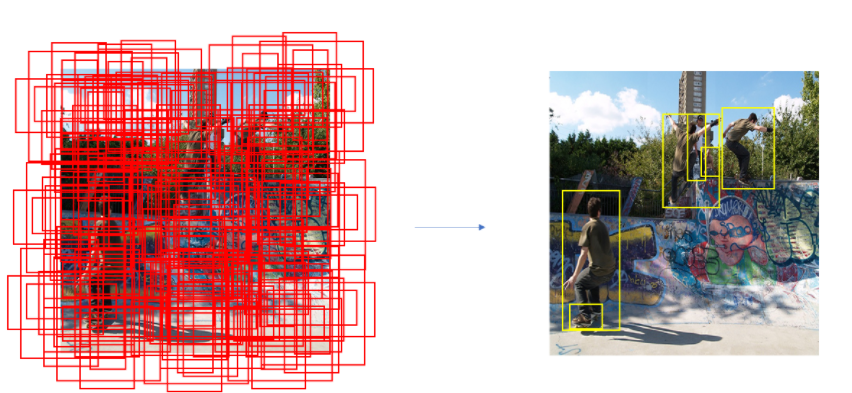  
  

##### 2)  Focal loss  
- 많이 사용되는 교차 엔트로피 기반으로 만들어졌음  
  -> 교차 엔트로피 CE(pt​) 앞에 간단히 modulating factor = (1−pt​)γ붙임  
  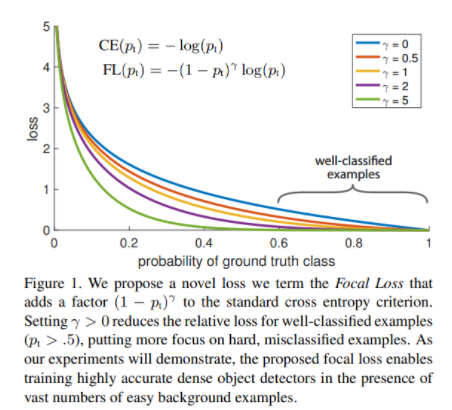  
  
  교차 엔트로피 개형을 보면 ground truth class에 대한 확률이 높으면  
  -> 잘 분류된 것으로 판단  
  -> 손실 loss가 줄어듦  
  -> 하지만 확률이 1에 가깝지 않은 이상 상당히 큰 손실로 이어짐  
  
  -> 이상황은 물체 검출 모델 학습시키는 과정에서 문제 생길 수 있음  
  -> 대부분 이미지에 물체보다 배경이 많음  
  -> 즉 이미지는 극단적으로 배경의 classs가 많은 class imbalanced data 임  
  -> 이렇게 많은 배경 class에 압도되지 않도록 modulating factor로 손실 조절  
  -> 람다= 0으로 설정하면  modulating factor= 0이 되어  
  -> 일반적인 교차 엔트로피가 되고, 람다가 커질수록  
  -> modulating이 강하게 적용되는 것 확인 가능  
   

#### 3. FPN(Feature Pyramid Network)  
##### 1) FPN 개념  
- 피라미드처럼 쌓아서 사용하는 방식  


- CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있음  
  -> 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고  
  -> 몇 개의 숫자로 요약해냄  
  -> 때문에 입력 이미지를 기준으로 생각하면  
  -> 입력이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 셀(cell)이 넓은 이미지 영역의 정보를 담고 있고  
  (레이어를 통과할 수록 이미지 정보가 압축되기 때문에 각 셀에는 동일한 한 개의 값이더라도 더 많은 정보를 담고있는 것)  
  -> 입력이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위 정보 담고 있음  
  -> 이를 receptive field라고 함  
  레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 되는 것  
  
  
- FPN 의미 : 백본의 여러 레이어를 한꺼번에 쓴다는 것의 의의가 있음  
  -> SSD은 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식  
  -> RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여  
  앞단의 특성 맵과 더해서 사용  
  => 레이어가 깊어질수록 feature map의 w,h방향의 receptive field가 넓어지는 것인데  
  넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적인 것  
  
  ! 여기서 잠깐 upsampling? : [CS231n - Lecture 11 | Detection and Segmentation](https://www.youtube.com/watch?v=nDPWywWRIRo)  
  
  
- RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지 아래 그림에서 확인  
  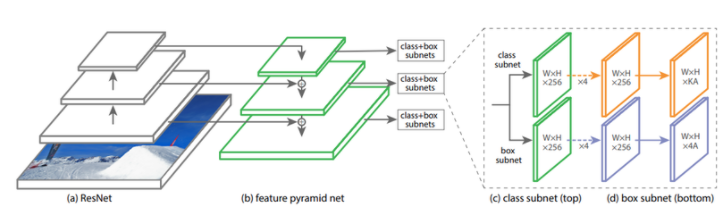  
  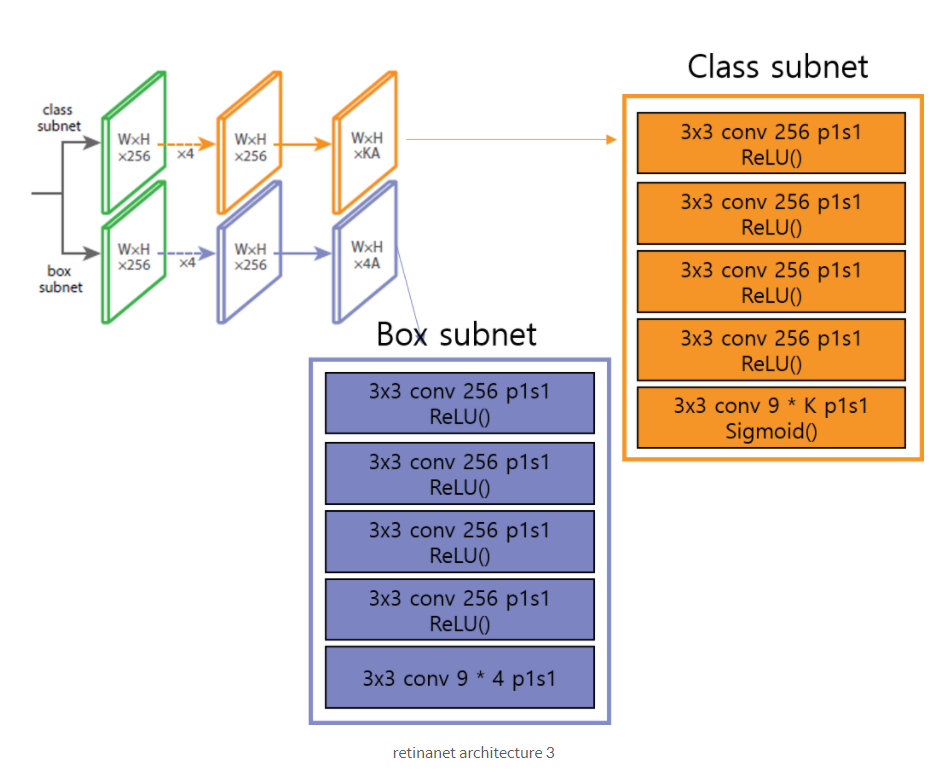  
  -> FPN 에서는 각 level이 256채널로 이루어짐  
  -> RetinaNet에서는 FPN의 P3​ 부터 P7​ 까지의 Pyramid level을 사용  
  -> 이를 통해 Classification Subnet과 Box Regression Subnet 2개의 Subnet을 구성  
  -> Anchor 갯수= A라고 하면  
  -> 최종적으로 Classification Subnet은 KK개 class에 대해 K* A개 채널  
  Box Regression Subnet은 4* A개 채널을 사용

## 5. keras-retinanet 실습 (1) 데이터 포맷 변경  
  
#### 1. Keras RetinaNet  
- 참고자료  
  [Keras RetineNet](https://github.com/fizyr/keras-retinanet)  
  
- Keras RetinaNet: 케라스(Keras) 라이브러리로 구현된 RetinaNet  
  -> 현재는 텐서플로우 2 버전을 지원하는 리포지토리(repository)도 만들어졌음  
  -> 그러나 아직 커스텀 데이터셋을 학습하는 방법을 공식 문서로 제시하지 않고 있음  
  -> 지금은 우선 Keras RetineNet 리포지토리를 이용  
  

- 우리가 가진 tensorflow_dataset의 KITTI 데이터셋 +  Keras RetinaNet 학습 위해서는  
  -> 라이브러리 수정해야함  
  -> 더 쉬운 방법은 해당 모델 훈련할 수 있는 공통된 데이터셋 포맷인  
  CSV 형태로 모델 변경해주는 방법  
  
  
#### 2. 클래스 및 바운딩 박스 정보 추출  
- tensorflow_dataset의 API 사용  
  -> 이미지, 각 이미지에 해당하는 바운딩 박스 라벨 정보 얻을 수 있음  
  -> API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장해보자  
  -> 1) 한 라인에 이미지 파일 위치, 바운딩 박스 위치, 클래스 정보 가지는 CSV파일 작성하도록 코드 작성  
  -> 2) 이를 사용해 CSV 파일 생성  
  <- ! 단, 우리가 생각하는 브레이크 시스템은 차, 사람 구분해야하는 점 유의  
  
  
- 데이터셋 포맷 예시  
  ```
  # 데이터셋 형식
path/to/image.jpg,x1,y1,x2,y2,class_name  
  # Example
/data/imgs/img_001.jpg,837,346,981,456,cow
  ```

- tqdm  
  루프문의 상태에 따라 콘솔에 진행 상황 바를 표시할 수 있는 라이브러리  
  [GitHub: tqdm](https://github.com/tqdm/tqdm)  

##### 1) 클래스 및 바운딩 박스 정보 추출

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [24:39<00:00,  4.29it/s]


##### 2) 테스트 데이터셋 dataframe 생성  
- parse_dataset() 적용 : 테스트 데이터셋에도 dataframe 생성  

In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
#test_csv_path : 원하는 폴더
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:51<00:00,  4.15it/s]


#### 2. 클래스 맵핑  
- 데이터셋에서 클래스는 문자열(string)으로 표시  
  -> 그러나 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 함  
  -> 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해두어야 함  
  -> 그래야 이후 학습한 후 론(inference)을 할 때에도  
  숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석 가능함  
  
##### 1) 클래스 맵핑 함수 생성  
- 라벨 : 차, 사람  

In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


## 6. keras-retinanet 실습 (2) 셋팅  
- 미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리를 사용  
  (위에서 미리 기본세팅할때 진행-> 쥬피터 말고 터미널에서 실행했음)  
  
##### 1) 모델 학습  
- 환경에 따라 batch_size나 worker, epoch를 조절해야 함  
- 훈련 이미지 크기 또는 batch_size가 너무 크면 GPU에서 out-of-memory 에러가 날 수 있으니 적절히 조정  
- 원 개발자는 8G 메모리도 RetinaNet을 훈련시키기에는 부족할 수 있다고 설명 중  
  [참고](https://github.com/fizyr/keras-retinanet/issues/499)  

In [10]:
#### RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2022-01-03 11:27:58.830865: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-01-03 11:27:58.830922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-03 11:28:00.398458: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-03 11:28:00.423851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 11:28:00.424652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClo

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 3.2855 - regression_loss: 2.6201 - classification_loss: 0.6654 
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 3662s 19s/step - loss: 3.2855 - regression_loss: 2.6201 - classification_loss: 0.6654
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 2.4456 - regression_loss: 2.1078 - classification_loss: 0.3378 
Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
195/195 [==============================] - 3676s 19s/step - loss: 2.4456 - regression_loss: 2.1078 - classification_loss: 0.3378
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 2.0446 - regression_loss: 1.7564 - classification_loss: 0.2882 
Epoch 00003: saving model to ./snapshots/resnet50_csv_03.h5
195/195 [==============================] - 3719s 19s/step - loss: 2.0446 - regression_loss: 1.7564 - classification_loss: 0.2882
Epoch 4/10
195/195 [===========

##### 2) 모델 변환  
- 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환  

In [11]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2022-01-03 23:05:18.213374: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-01-03 23:05:18.213564: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-03 23:05:21.921505: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-03 23:05:21.949139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 23:05:21.955123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClo

## 7. keras-retinanet 실습 (3) 시각화  
- 위에서 변환한 모델을 load하고 추론 및 시각화 진행  
  <- 일정 점수 이하는 경우를 제거해야 함을 유의해야함 !  
  
- 적당한 이미지 7개로 진행  


In [12]:
! mkdir -p ~/aiffel/object_detection/test_set
! ln -s ~/data/*.png ~/aiffel/object_detection/test_set

ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/go_1.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/go_2.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/go_3.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/go_4.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/go_5.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/stop_1.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/stop_2.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/stop_3.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/stop_4.png': File exists
ln: failed to create symbolic link '/aiffel/aiffel/object_detection/test_set/stop_5.png': Fi

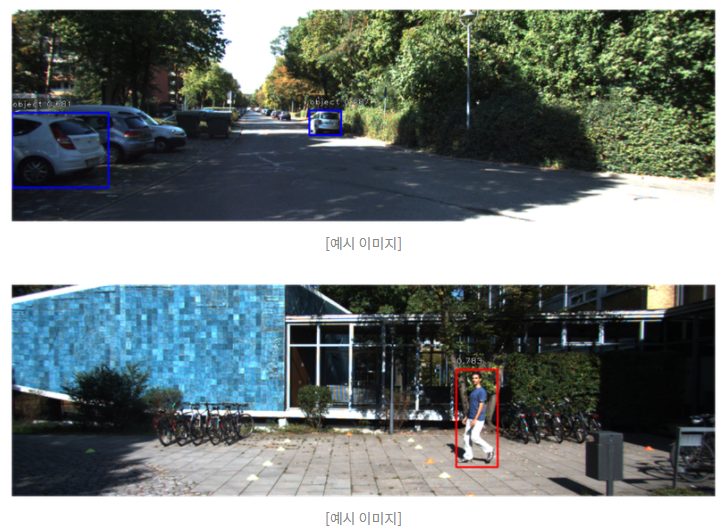  


- 필요 라이브러리 import & 경로 저장

In [13]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

- 결과 확인 함수 생성  

[594.7143  176.20056 624.51355 205.9291 ]
[195.96419 138.37285 356.78986 231.09518]
[380.72522 184.31306 413.9719  209.87723]
[533.5727  162.00006 563.8672  190.29782]


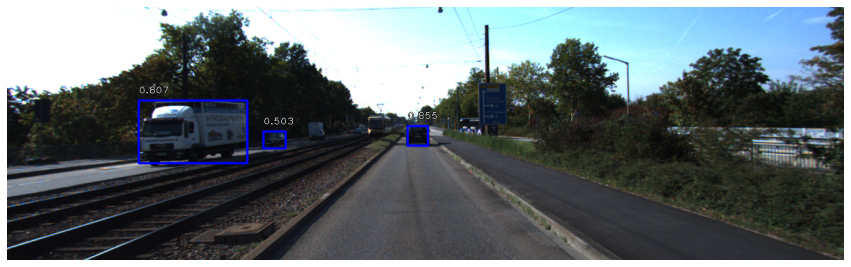

In [14]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

- 다른 이미지도 확인

[772.01483 153.03809 851.7579  316.1965 ]
[767.69244 154.22765 859.2267  307.27008]


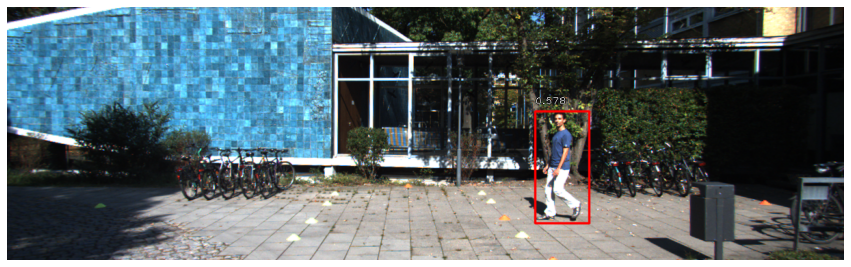

In [15]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

## 8. 프로젝트: 자율주행 보조 시스템 만들기  
#### 1. 자율 주행 시스템 만들기  
- 위에서 만든 모델로 다음 조건 만족하는 함수 생성  
  1) 입력으로 이미지 경로를 받기  
  2) 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환  
  3) 정지 조건  
     - 1 사람이 한명 이상 있는 경우  
     - 2 차량의 크기(width or height)가 300px이상인 경우

In [16]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.5: break
        if label == 1: return 'Stop'# 사람이 한 명 이상 있는 경우
        elif label == 0: # 자동차가 있는 경우
            # 자동차 크기(너비 또는 높이)가 300px이상일 경우 Stop 반환
            if abs(box[0]-box[2]) >= 300 or abs(box[1]-box[3]) >= 300: return 'Stop'
    
    # 위 2개의 조건 모두 해당하지 않는다면 Go 반환
    return 'Go'

print(self_drive_assist(img_path))

Stop


Stop
[772.01483 153.03809 851.7579  316.1965 ]
[767.69244 154.22765 859.2267  307.27008]


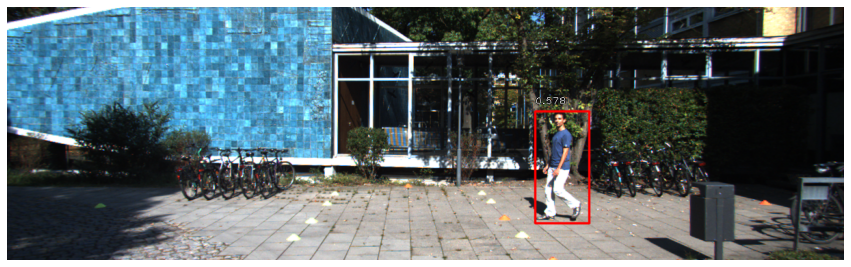

None


In [17]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
print(self_drive_assist(img_path))
print(inference_on_image(model, img_path=img_path))

#### 2. 자율주행 시스템 평가하기  
- 아래 test_system() 를 통해서 위에서 만든 함수를 평가  
  -> 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줌  

In [18]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.


## 회고  

#### 💚루브릭  
##### 1)  KITTI 데이터셋에 대한 분석이 체계적으로 진행되었는가?  
- KITTI 데이터셋 구조와 내용을 파악  
- 필요한 데이터셋 가공을 정상 진행  

##### 2) RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었는가?  
- 바운딩박스가 정확히 표시된 시각화된 이미지를 생성  

##### 3) 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였는가?  
- 테스트 수행결과 90% 이상의 정확도 보임  

#### 💚회고록  
##### 1) Retinanet  
- 공부했던 내용들은 위에 있기 때문에 생략  
- 새로운 네트워크를 배울때 항상 재밌는데  
  이번에도 새로운 아이디어를 배우면서 재밌었다  
  추가적으로 공부했던 자료  
  1) [논문리뷰 1](https://ropiens.tistory.com/83)  
  2) [논문리뷰 2](https://deep-learning-study.tistory.com/504)  
  3) [논문리뷰 3](https://herbwood.tistory.com/19)  
  문제 정의 -> 해결 -> 실험으로 증명 하는 논문 프로세스가  
  이제는 익숙해졌고 기술 자체도 가치 있지만  
  어떤 문제를 해결하고자 했는가  
  그래서 결국엔 이 기술이 어떤 밸류를 가지는 가를 느낄때  
  너무 재밌고, 이런걸 배우는 본인에게 성취감도 많이 느낀다  
  언젠가,, 나도 어떤 문제를 정의하고  
  또 이를 해결하기 위한 일련의 노력하는 과정들을 진행할 수 있는 사람이 될 수 있기를 !  
  
##### 2) 개선하고 싶은 점   
- 해당 프로젝트에서는 학습 돌리는 데에 많은 시간이 소요되어서  
  하이퍼 파라미터들을 다양하게 학습시켜 보고 싶었는데  
  시간이 생각보다 촉박해서 진행하지 못해봤다  
  좋은 결과를 얻긴했지만, 좋지 않은 결과도 확인해보고 싶다  

##### 3) 기타 다른 생각  
- 자율주행 딥러닝은 loss가 아무리 적더라도  
  loss 가 항상 0으로 수렴해야 할 것 이다  
  사람들의 목숨과 직결되어 있는 문제이기 때문이다  
  최근 자율주행을 위해서 강화학습, 관계형 추론, 지능이식과 같은 기술들이  
  접목되고 있다고 한다  
  [자율주행 AI에 대한 한 아티클](https://www.epnc.co.kr/news/articleView.html?idxno=113267)  
  아직 개선되어야 할 점이 많다 = 도전해볼 것이 많다 !  
  
  
  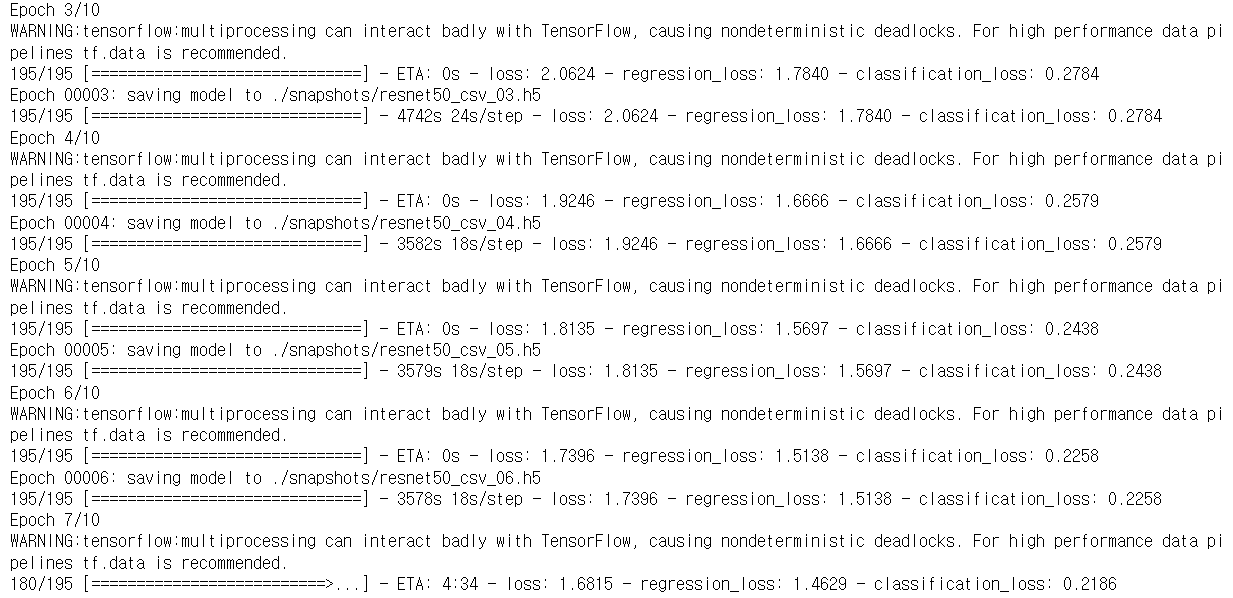